In [49]:
#Testing Iris dataset
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [4]:
#get data and target
data, target =load_iris(return_X_y=True)
colnames=load_iris().feature_names
targetnames=load_iris().target_names
data=pd.DataFrame(data, columns=colnames)

0.9466666666666667


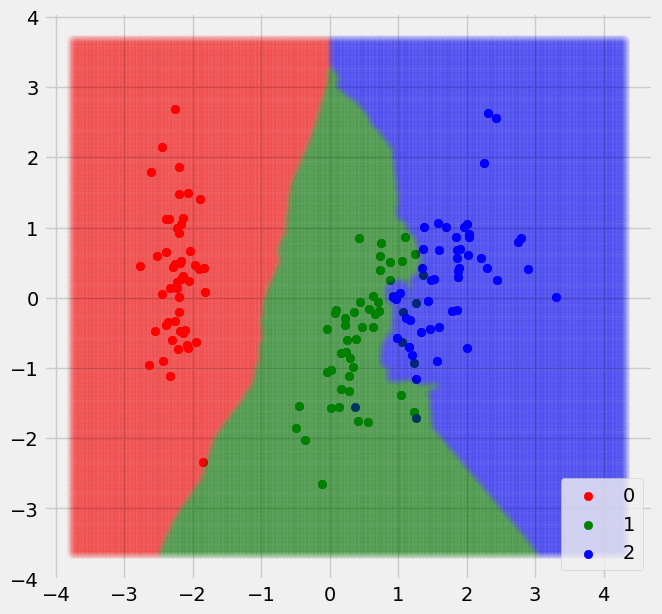

In [129]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import clear_output

#data exploration

#data.isna().sum()
#data.describe()

#visualizing PCA 2 dimen
scaleddata=StandardScaler().fit_transform(data)
twodimendata=PCA(n_components=2, random_state=1231).fit_transform(scaleddata)

colours=["red", "green", "blue"]
fig, ax = plt.subplots(figsize=(7,7))
for i in np.unique(target):
    ax.scatter(twodimendata[target==i,0], twodimendata[target==i,1], c=colours[i], label=str(i))
ax.legend(loc="lower right")

#plotting area of each category with PCA (Kneighbour method)
size=400
min_x, min_y= twodimendata[:,0].min() -1, twodimendata[:,1].min() -1
max_x, max_y= twodimendata[:,0].max() +1, twodimendata[:,1].max() +1
xx=np.linspace(min_x, max_x, size)
yy=np.linspace(min_y, max_y, size)
xx, yy =np.meshgrid(xx, yy)
xy=np.array([xx.flatten(), yy.flatten()]).T

modelkn=KNeighborsClassifier().fit(twodimendata, target)
print(modelkn.score(twodimendata, target))
predictedxy=modelkn.predict(xy)

for i in np.unique(predictedxy):
    ax.scatter(xy[predictedxy==i,0], xy[predictedxy==i,1], c=colours[i], alpha=0.0)
    
plt.show()                                                                              #IDK why i use Kneighbour tbh

In [6]:
#splitting train test
train_data, test_data, train_target, test_target=train_test_split(data, target, random_state=43231, train_size=0.8)

#get feature names
feature_column=[]
for i in colnames:
    uniqueword=data[i].unique()
    feature_column.append(tf.feature_column.categorical_column_with_vocabulary_list(i, uniqueword)) if data[i].dtype=="object" else feature_column.append(tf.feature_column.numeric_column(i))
print(feature_column)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
[NumericColumn(key='sepal length (cm)', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='sepal width (cm)', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='petal length (cm)', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='petal width (cm)', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [7]:
#create input model
def get_input_fn(data, target, batchsize=32,shuffle=True, epochs=10):
    def input_fn():
        ds=tf.data.Dataset.from_tensor_slices((dict(data), target))
        if shuffle:
            ds=ds.shuffle(10)
        ds=ds.batch(batchsize).repeat(epochs)
        return ds
    return input_fn

train_fn=get_input_fn(train_data, train_target)
test_fn=get_input_fn(test_data, test_target, epochs=1, shuffle=False)
#list(test_fn().as_numpy_iterator())[0]

In [8]:
#get regmodel
regmodel = tf.estimator.LinearClassifier(feature_columns=feature_column, n_classes=np.unique(target).size)
regmodel.train(train_fn)
evaluate=regmodel.evaluate(test_fn)
clear_output()
evaluate["accuracy"]

0.76666665

In [42]:
#def predictshit
def get_predict_fn(data, batch_size=1):
    def predict_fn():
        ds=tf.data.Dataset.from_tensor_slices((dict(data))).batch(batch_size)
        return ds
    return predict_fn

def trynnapredict(urdata):
    urdata=pd.DataFrame(urdata, columns=colnames)
    temp=get_predict_fn(urdata)
    predicted=list(regmodel.predict(temp))
    return predicted

dummy=[[4.3,3.2,2.1,1.1]]

z=trynnapredict(dummy)
z[0]["class_ids"]

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Rhey\AppData\Local\Temp\tmpkpigd1nh\model.ckpt-40
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[0]


In [126]:
#Using PCA to classify and mapped the entire plot with the entire data!
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(data)
scaleddata=scaler.transform(data)

modelPCA=PCA(n_components=2).fit(scaleddata)
PCAdata=modelPCA.transform(scaleddata)

#fitting the data into regmodel
feature_column=[tf.feature_column.numeric_column(i) for i in ["x","y"]]
regmodel=tf.estimator.LinearClassifier(feature_column, n_classes=np.unique(target).size)
PCAdata_FN=get_input_fn(dict(pd.DataFrame(PCAdata, columns=["x","y"])), target)
regmodel.train(PCAdata_FN)
clear_output()
regmodel.evaluate(PCAdata_FN)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-08-15T11:54:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Rhey\AppData\Local\Temp\tmpzb2hzxnk\model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.39317s
INFO:tensorflow:Finished evaluation at 2023-08-15-11:54:51
INFO:tensorflow:Saving dict for global step 50: accuracy = 0.84, average_loss = 0.4088589, global_step = 50, loss = 0.4025245
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 50: C:\Users\Rhey\AppData\Local\Temp\tmpzb2hzxnk\model.ckpt-50


{'accuracy': 0.84,
 'average_loss': 0.4088589,
 'loss': 0.4025245,
 'global_step': 50}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Rhey\AppData\Local\Temp\tmpzb2hzxnk\model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


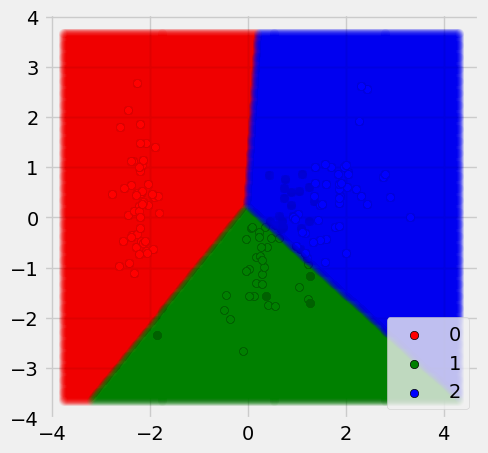

In [135]:
#def predictshit
def get_predict_fn(data, batch_size=32):
    def predict_fn():
        ds=tf.data.Dataset.from_tensor_slices((dict(data))).batch(batch_size)
        return ds
    return predict_fn

def trynnapredict(urdata):
    urdata=pd.DataFrame(urdata, columns=["x","y"])
    temp=get_predict_fn(urdata)
    predicted=list(regmodel.predict(temp))
    return predicted

#meshgrid xD

predictedxy=trynnapredict(xy)
targetpredictedxy=np.array([predictedxy[i]["class_ids"] for i in range(len(predictedxy))]).flatten()

fig, ax =plt.subplots(figsize=(5,5))
for i in np.unique(target):
    ax.scatter(PCAdata[target==i, 0], PCAdata[target==i,1], c=colours[i], label=str(i), edgecolors="black")
ax.legend(loc="lower right")

for i in np.unique(targetpredictedxy):
    ax.scatter(xy[targetpredictedxy==i,0], xy[targetpredictedxy==i,1], c=colours[i], alpha=0.03)
plt.show()